In [1]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 34.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195842 sha256=bf09b02a67ae732700dbb06c68ab528f5ad272ade7cca815a47d7a0ebff0ee09
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [2]:
! pip install scikit-surprise
from surprise import KNNBasic
from surprise import Dataset
from surprise import Reader

from collections import defaultdict
from operator import itemgetter
import heapq

import os
import csv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [4]:
#Import relevant libraries
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#movies dataset
movies_dataset=pd.read_csv('ml-latest-small/movies.csv')
movies_dataset.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
#Import the ratings csv file 
ratings_dataset = pd.read_csv('ml-latest-small/ratings.csv')
ratings_dataset.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
#Merging movies and ratings datasets
df = pd.merge(ratings_dataset, movies_dataset, on='movieId', how='left')
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [9]:
#checking the sparsity of the matrix
rating_count = len(df['rating'])
user_count = len(df['userId'].unique())
item_count = len(df['movieId'].unique())

sparsity = 1 - (rating_count / (user_count*item_count))
sparsity

0.9830003169443864

In [10]:
#The matrix is very sparse
#Reducing the sparsity
data = df.groupby('userId').count()
sorted_data = data.sort_values(by='movieId', ascending=True)
sorted_data

,movieId,rating,timestamp,title,genres
userId,,,,,
442,20,20,20,20,20
406,20,20,20,20,20
147,20,20,20,20,20
194,20,20,20,20,20
569,20,20,20,20,20
...,...,...,...,...,...
274,1346,1346,1346,1346,1346
448,1864,1864,1864,1864,1864
474,2108,2108,2108,2108,2108


In [11]:
#Filtering out users who have rated less than 100 movies 
df = df.groupby('userId').filter(lambda x: len(x)>100)

In [12]:
#Filtering out movies who have been rated by less than 10 users 
df = df.groupby('movieId').filter(lambda x: len(x)>10)
df.head(10)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
5,1,70,3.0,964982400,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
6,1,101,5.0,964980868,Bottle Rocket (1996),Adventure|Comedy|Crime|Romance
7,1,110,4.0,964982176,Braveheart (1995),Action|Drama|War
8,1,151,5.0,964984041,Rob Roy (1995),Action|Drama|Romance|War
9,1,157,5.0,964984100,Canadian Bacon (1995),Comedy|War


In [13]:
#checking the sparsity of the matrix
rating_count = len(df['rating'])
user_count = len(df['userId'].unique())
item_count = len(df['movieId'].unique())

sparsity = 1 - (rating_count / (user_count*item_count))
sparsity

0.8684984374016822

In [14]:
# Group by movie ID and count the number of ratings for each movie
movie_ratings = df.groupby('movieId')['rating'].count()

# Sort the movie ratings in ascending order
sorted_movie_ratings = movie_ratings.sort_values(ascending=True)

# Print the sorted movie ratings
print(sorted_movie_ratings.head(10))


movieId
5065      11
48783     11
47629     11
3189      11
46335     11
174055    11
45880     11
3270      11
3316      11
900       11
Name: rating, dtype: int64


In [15]:
#Adding a feature 'year' that shows which year the movie is from 
df['year'] = df['title'].str.extract('.*\((.*)\).*',expand = False)
df.head(5)

,userId,movieId,rating,timestamp,title,genres,year
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,1995
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,1995
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995


In [16]:
#Finding the average ratings of movies 
df.groupby('title').mean()['rating'].sort_values(ascending=False)

<ipython-input-16-8a6abcbf80d4>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('title').mean()['rating'].sort_values(ascending=False)


title
Guess Who's Coming to Dinner (1967)           4.545455
Paths of Glory (1957)                         4.545455
Shawshank Redemption, The (1994)              4.425000
Celebration, The (Festen) (1998)              4.409091
Patton (1970)                                 4.400000
                                                ...   
Superman IV: The Quest for Peace (1987)       1.687500
Flintstones in Viva Rock Vegas, The (2000)    1.681818
Battlefield Earth (2000)                      1.676471
Speed 2: Cruise Control (1997)                1.633333
Problem Child (1990)                          1.583333
Name: rating, Length: 1946, dtype: float64

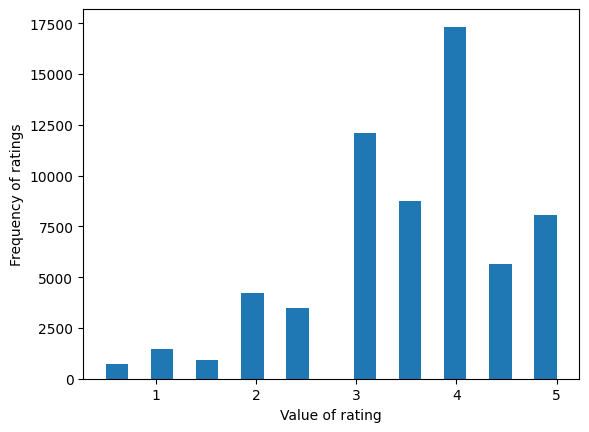

In [17]:
#Plot a histogram of the frequency of certain rating values
plt.hist(df['rating'],bins=20)
plt.xlabel('Value of rating')
plt.ylabel('Frequency of ratings')
plt.show()

In [18]:
#Creating genre types
genretypes = set()
for i in df['genres'].str.split('|').values:
    genretypes = genretypes.union(set(i))
genretypes

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [19]:
#Creating function that counts how many movies there are of each genre 
def genrecounts(df, col, gen_types):
    count = {}
    for i in gen_types:
       count[i] = 0
    for value in df[col].str.split('|'):
        if type(value) == float and pd.isnull(value): 
          continue
        for i in value: 
            if pd.notnull(i): 
              count[i] += 1
    return count
genre_count = genrecounts(df, 'genres', genretypes)
genre_count
        

{'Crime': 10929,
 'Action': 21440,
 'Western': 1207,
 'Musical': 2714,
 'Romance': 11275,
 'Comedy': 24625,
 'IMAX': 3055,
 'Fantasy': 8323,
 'Mystery': 5158,
 'Horror': 4109,
 'War': 3052,
 'Animation': 4578,
 'Thriller': 17360,
 'Film-Noir': 606,
 'Adventure': 17212,
 'Children': 6112,
 'Sci-Fi': 12508,
 'Drama': 24842,
 'Documentary': 287}

In [20]:
#Create a dataframe for the genres and their value counts 
genres = pd.DataFrame(list(genre_count.items()),columns = ['Genre','Count'])
#Sort the DataFrame
genres = genres.sort_values(by=['Count'], ascending=False)
genres

,Genre,Count
17,Drama,24842
5,Comedy,24625
1,Action,21440
12,Thriller,17360
14,Adventure,17212
16,Sci-Fi,12508
4,Romance,11275
0,Crime,10929
7,Fantasy,8323
15,Children,6112


In [21]:
#Create columns for each genre to indicate T/F
for genre in genretypes:
    df[genre] = df['genres'].apply(lambda x: genre in x)
df.head(5)

,userId,movieId,rating,timestamp,title,genres,year,Crime,Action,Western,...,Horror,War,Animation,Thriller,Film-Noir,Adventure,Children,Sci-Fi,Drama,Documentary
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,False,False,False,...,False,False,True,False,False,True,True,False,False,False
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,1995,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,1995,True,True,False,...,False,False,False,True,False,False,False,False,False,False
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,1995,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,1995,True,False,False,...,False,False,False,True,False,False,False,False,False,False


In [22]:
#Create a logical matrix now that the genres have been parsed.
genrematrix = df.drop(['userId', 'movieId', 'rating', 'genres', 'year','timestamp'], axis=1)
genrematrix.head(5)

,title,Crime,Action,Western,Musical,Romance,Comedy,IMAX,Fantasy,Mystery,Horror,War,Animation,Thriller,Film-Noir,Adventure,Children,Sci-Fi,Drama,Documentary
0,Toy Story (1995),False,False,False,False,False,True,False,True,False,False,False,True,False,False,True,True,False,False,False
1,Grumpier Old Men (1995),False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,Heat (1995),True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,Seven (a.k.a. Se7en) (1995),False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
4,"Usual Suspects, The (1995)",True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False


In [23]:
#Now considering the original dataset for more analysis
#df for modelling
df2=df[['userId', 'movieId', 'rating']]
df2.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [24]:
import pandas as pd
from surprise import Dataset, Reader, SVD
from sklearn.model_selection import train_test_split
from surprise import accuracy
train_dfs = []
test_dfs = []
users = df2['userId'].unique()
for user in users:
    user_df = df2[df2['userId'] == user]
    train_df, test_df = train_test_split(user_df, test_size=0.2, random_state=42)
    train_dfs.append(train_df)
    test_dfs.append(test_df)

# Combine the training and testing sets from all users
train_df = pd.concat(train_dfs)
test_df = pd.concat(test_dfs)

reader = Reader(rating_scale=(0, 5))
trainset = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
testset = Dataset.load_from_df(test_df[['userId', 'movieId', 'rating']], reader)
trainset = trainset.construct_trainset(trainset.raw_ratings)
testset = testset.construct_testset(testset.raw_ratings)



In [25]:
#Model 1: SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
#Set parameters for GridSearch on SVD model 
parameters = {'n_factors': [20, 50, 80],
             'reg_all': [0.04, 0.06],
             'n_epochs': [10, 20, 30],
             'lr_all': [.002, .005, .01]}
gridsvd = GridSearchCV(SVD, param_grid=parameters, n_jobs=-1)
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df2[['userId', 'movieId', 'rating']], reader)
#Fit SVD model on data
gridsvd.fit(data)
#Print best score and best parameters from the GridSearch 
print(gridsvd.best_score)
print(gridsvd.best_params)
#Reinstantiate the model with the best parameters fromGridSearch 
svdtuned = SVD(n_factors=80,
               reg_all=0.06,
               n_epochs=30,
               lr_all=0.01)
#Fit and predict the model 
svdtuned.fit(trainset)
svdpreds = svdtuned.test(testset)
#Print RMSE and MAE results 
accuracy.rmse(svdpreds)
accuracy.mae(svdpreds)

{'rmse': 0.8161101478358705, 'mae': 0.6242605338005465}
{'rmse': {'n_factors': 80, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.01}, 'mae': {'n_factors': 80, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.01}}
RMSE: 0.8151
MAE:  0.6202


0.6202055068109688

In [26]:
#Perform 3-Fold cross validation for SVD tuned model
cv_svd_tuned = cross_validate(svdtuned, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8212  0.8284  0.8262  0.8253  0.0030  
MAE (testset)     0.6290  0.6342  0.6304  0.6312  0.0022  
Fit time          1.08    0.98    1.09    1.05    0.05    
Test time         0.18    0.41    0.14    0.24    0.12    


In [27]:
np.mean(cv_svd_tuned['test_rmse'])

0.825275214279548

In [28]:
np.mean(cv_svd_tuned['test_mae'])

0.6312096059087903

In [29]:
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import SVD, Dataset, Reader
from sklearn.metrics import classification_report
from surprise import accuracy
from sklearn.metrics import classification_report, accuracy_score

# Print RMSE and MAE results 
print("RMSE:", accuracy.rmse(svdpreds))
print("MAE:", accuracy.mae(svdpreds))
threshold = 3.0
y_true = [1 if r >= threshold else 0 for (_, _, r) in testset]
y_pred = [1 if p.est >= threshold else 0 for p in svdpreds]
# Calculate and print the classification report
print(classification_report(y_true, y_pred))
# Calculate and print the accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")


RMSE: 0.8151
RMSE: 0.8151254223176027
MAE:  0.6202
MAE: 0.6202055068109688
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      2184
           1       0.90      0.90      0.90     10456

    accuracy                           0.83     12640
   macro avg       0.70      0.70      0.70     12640
weighted avg       0.83      0.83      0.83     12640

Accuracy: 0.828


In [30]:
from collections import defaultdict
from surprise import Dataset

# Get a list of all the users in the testing set
test_users = set([u for (u, i, r) in testset])

# Create a dictionary to store the recommendation lists for each user
recommendations = defaultdict(list)

# Loop over each test user
for user in test_users:
    # Get the items that the user has not rated
    anti_testset = trainset.build_anti_testset(fill=0)
    anti_testset = filter(lambda x: x[0] == user, anti_testset)
    
    # Get the predicted ratings for the items
    predictions = svdtuned.test(anti_testset)
    
    # Sort the items based on their predicted ratings
    predictions.sort(key=lambda x: x.est, reverse=True)
    
    # Add the top 10 items to the recommendation list for the user
    for i in range(10):
        if predictions[i][1] not in trainset.ur[user]:
            recommendations[user].append(predictions[i][1])


In [31]:
# Create a mapping of movie IDs to movie names
id_name_map = {}
for row in df2.itertuples():
    id_name_map[row[2]] = row[3]

# Get the top 10 recommendations for each user in the test set
recommendations = defaultdict(list)
for uid, iid, r_ui, est, _ in svdpreds:
    if r_ui >= threshold and iid not in trainset.ur[uid]:
        recommendations[uid].append((iid, est))
for uid, user_recommendations in recommendations.items():
    user_recommendations.sort(key=lambda x: x[1], reverse=True)
    top_items = [id_name_map[iid] for (iid, _) in user_recommendations[:10]]
    print(f"User {uid}: {top_items}")

User 1: [5.0, 5.0, 3.5, 5.0, 5.0, 5.0, 5.0, 4.0, 2.5, 3.5]
User 4: [5.0, 4.5, 3.5, 3.0, 2.0, 3.5, 5.0, 4.0, 3.0, 3.5]
User 6: [3.5, 3.0, 4.0, 2.0, 4.0, 4.0, 4.5, 2.5, 3.5, 2.5]
User 7: [3.0, 2.0, 4.0, 2.5, 4.0, 3.5, 4.5, 3.5, 3.5, 4.0]
User 10: [3.5, 4.5, 5.0, 4.5, 3.0, 4.0, 4.0, 4.0, 3.5, 3.5]
User 15: [4.0, 4.5, 4.0, 3.5, 3.0, 3.0, 4.5, 5.0, 5.0, 5.0]
User 17: [3.0, 4.5, 3.5, 4.5, 5.0, 5.0, 4.5, 4.0, 5.0, 4.5]
User 18: [3.0, 5.0, 5.0, 4.0, 3.5, 4.5, 5.0, 4.0, 5.0, 5.0]
User 19: [5.0, 5.0, 4.5, 5.0, 4.5, 3.0, 5.0, 4.0, 5.0, 5.0]
User 20: [4.5, 3.0, 2.5, 3.5, 5.0, 4.0, 3.5, 4.5, 3.0, 4.5]
User 21: [5.0, 3.5, 3.5, 5.0, 4.5, 3.5, 4.5, 4.0, 4.5, 3.5]
User 22: [5.0, 4.0, 4.0, 3.0, 2.5, 4.5, 5.0, 5.0, 5.0, 3.0]
User 23: [4.0, 5.0, 4.0, 4.5, 5.0, 4.0, 3.0, 5.0, 5.0, 4.0]
User 24: [4.5, 4.5, 4.5, 5.0, 3.5, 3.5, 4.5, 5.0, 5.0, 5.0]
User 27: [2.0, 5.0, 3.5, 5.0, 5.0, 2.5, 5.0, 2.0, 3.0, 3.5]
User 28: [5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 3.5, 4.5]
User 32: [5.0, 4.5, 3.5, 2.0, 4.0, 5.0, 4.0,

In [32]:
# Create a dictionary to map movie ids to movie names
movies_df = pd.read_csv('ml-latest-small/movies.csv')
movie_id_to_name = dict(zip(movies_df['movieId'], movies_df['title']))

In [33]:
# Create a dictionary to map user ids to movie ids that they have rated
user_to_rated_movies = {}
for (user_id, movie_id, rating) in trainset.all_ratings():
    if user_id not in user_to_rated_movies:
        user_to_rated_movies[user_id] = set()
    user_to_rated_movies[user_id].add(movie_id)


In [34]:
# Generate a recommendation list for each user in the testing set
from surprise import SVD

# Define the SVD algorithm
algo = SVD()

# Fit the algorithm on the trainset
algo.fit(trainset)
recommendations = {}
for user_id in set([x[0] for x in testset]):
    user_ratings = [(movie_id, algo.predict(user_id, movie_id)[3]) for movie_id in movie_id_to_name.keys()
                    if movie_id not in user_to_rated_movies.get(user_id, set())]
    top_rated_movies = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:10]
    recommendations[user_id] = [(movie_id_to_name[movie_id], rating) for (movie_id, rating) in top_rated_movies]

# Print the recommendations for each user in the testing set
for user_id, movies in recommendations.items():
    print(f"User {user_id} may like:")
    for movie_name, rating in movies:
        print(f"- {movie_name} (predicted rating: {rating:.2f})")



User 1 may like:
- Usual Suspects, The (1995) (predicted rating: 5.00)
- Shawshank Redemption, The (1994) (predicted rating: 5.00)
- Schindler's List (1993) (predicted rating: 5.00)
- Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (predicted rating: 5.00)
- Philadelphia Story, The (1940) (predicted rating: 5.00)
- Rear Window (1954) (predicted rating: 5.00)
- Casablanca (1942) (predicted rating: 5.00)
- Wizard of Oz, The (1939) (predicted rating: 5.00)
- His Girl Friday (1940) (predicted rating: 5.00)
- Streetcar Named Desire, A (1951) (predicted rating: 5.00)
User 514 may like:
- Fight Club (1999) (predicted rating: 4.69)
- Star Wars: Episode V - The Empire Strikes Back (1980) (predicted rating: 4.60)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) (predicted rating: 4.53)
- Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) (predicted rating: 4.45)
- Star Wars: Episode IV - A New Hope (1977) (predicted rating: 4.45)
- Gr

In [35]:
from collections import defaultdict
from surprise import accuracy

# Define a function to calculate precision, recall and F-measure for each user
def evaluate_recommendations(predictions, top_n=10, threshold=3.0):
    precisions = defaultdict(list)
    recalls = defaultdict(list)
    f_measures = defaultdict(list)
    ndcgs = defaultdict(list)

    # Group predictions by user ID
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r, iid))

    # Loop through each user
    for uid, user_ratings in user_est_true.items():
        # Sort the ratings by estimated value in descending order
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Split the ratings into top N recommendations and the rest
        top_n_ratings = user_ratings[:top_n]
        other_ratings = user_ratings[top_n:]

        # Calculate the number of testing items in the top N recommendations
        num_hits = sum([int(true_r >= threshold) for (_, true_r, _) in top_n_ratings])

        # Calculate precision, recall, F-measure and NDCG
        num_tested = len([r for (_, r, _) in user_ratings if r >= threshold])
        num_recommended = len(top_n_ratings)
        precision = num_hits / num_recommended
        recall = num_hits / num_tested if num_tested > 0 else 0
        f_measure = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
        ndcg = 0
        for i, (_, true_r, _) in enumerate(top_n_ratings):
            ndcg += (2 ** true_r - 1) / (i + 1)
        for (_, true_r, _) in other_ratings:
            ndcg += (2 ** true_r - 1) / num_recommended
        ndcg /= sum([1 / (i + 1) for i in range(min(num_tested, num_recommended))])

        # Append the results to the corresponding lists
        precisions[uid].append(precision)
        recalls[uid].append(recall)
        f_measures[uid].append(f_measure)
        ndcgs[uid].append(ndcg)

    # Calculate the average of precision, recall, F-measure and NDCG over all users
    avg_precision = sum([sum(precisions[uid]) / len(precisions[uid]) for uid in precisions]) / len(precisions)
    avg_recall = sum([sum(recalls[uid]) / len(recalls[uid]) for uid in recalls]) / len(recalls)
    avg_f_measure = sum([sum(f_measures[uid]) / len(f_measures[uid]) for uid in f_measures]) / len(f_measures)
    avg_ndcg = sum([sum(ndcgs[uid]) / len(ndcgs[uid]) for uid in ndcgs]) / len(ndcgs)

    # Print the results
    print(f"Precision@{top_n}: {avg_precision:.4f}")
    print(f"Recall@{top_n}: {avg_recall:.4f}")
    print(f"F1 score@{top_n}: {(2 * avg_precision * avg_recall) / (avg_precision + avg_recall):.4f}")
    print(f"NDCG@{top_n}: {avg_ndcg:.4f}")
# Evaluate the quality of the recommendation list
predictions = algo.test(testset)
evaluate_recommendations(predictions)

Precision@10: 0.9155
Recall@10: 0.3146
F1 score@10: 0.4683
NDCG@10: 36.1757


In [36]:
print(recommendations)

{1: [('Usual Suspects, The (1995)', 5), ('Shawshank Redemption, The (1994)', 5), ("Schindler's List (1993)", 5), ('Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 5), ('Philadelphia Story, The (1940)', 5), ('Rear Window (1954)', 5), ('Casablanca (1942)', 5), ('Wizard of Oz, The (1939)', 5), ('His Girl Friday (1940)', 5), ('Streetcar Named Desire, A (1951)', 5)], 514: [('Fight Club (1999)', 4.68967370364372), ('Star Wars: Episode V - The Empire Strikes Back (1980)', 4.6034793849427675), ('Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 4.531216507148462), ("Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)", 4.451024405181054), ('Star Wars: Episode IV - A New Hope (1977)', 4.448947733997885), ('Great Escape, The (1963)', 4.430496119975667), ('Shawshank Redemption, The (1994)', 4.399245304932955), ('Princess Bride, The (1987)', 4.374427386114142), ('Matrix, The (1999)', 4.372164052789635), ('Godfather, The (1972)', 4.37022

Model:KNN

In [37]:
# Set parameters to be used in KNN models 
knn_params = {'name': ['cosine', 'pearson'],
              'user_based':[True, False], 
              'min_support':[True, False],
            'min_k' : [1, 2]}

In [38]:
gridsvd = GridSearchCV(SVD, param_grid=parameters, n_jobs=-1)
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df2[['userId', 'movieId', 'rating']], reader)
#Fit SVD model on data
gridsvd.fit(data)
#Print best score and best parameters from the GridSearch 
print(gridsvd.best_score)
print(gridsvd.best_params)
#Reinstantiate the model with the best parameters fromGridSearch 
svdtuned = SVD(n_factors=80,
               reg_all=0.06,
               n_epochs=30,
               lr_all=0.01)
#Fit and predict the model 
svdtuned.fit(trainset)
svdpreds = svdtuned.test(testset)
#Print RMSE and MAE results 
accuracy.rmse(svdpreds)
accuracy.mae(svdpreds)

{'rmse': 0.8163413314755259, 'mae': 0.6235778132303853}
{'rmse': {'n_factors': 50, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.01}, 'mae': {'n_factors': 50, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.01}}
RMSE: 0.8167
MAE:  0.6200


0.6199983177744778

In [39]:
# Apply GridSearch to the KNN Basic model to identify the best parameters
gsknnbasic = GridSearchCV(KNNBasic, knn_params, measures=['rmse', 'mae'], cv=3)
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df2[['userId', 'movieId', 'rating']], reader)
#Fit KNNBasic model on data
gsknnbasic.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [40]:
#Display the best scores and parameters from GridSearch
print(gsknnbasic.best_score)
print(gsknnbasic.best_params)

{'rmse': 0.9028006654153115, 'mae': 0.6959283493161724}
{'rmse': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 1}, 'mae': {'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 1}}


In [41]:
#Reinstantiate the model with the best parameters from GridSearch 
knnbasic_tuned = KNNBasic(sim_options={'name': 'cosine', 'user_based': True, 'min_support': True, 'min_k': 1 })

In [42]:
#Fit and predict the model 
knnbasic_tuned.fit(trainset)
knnbasic_preds = knnbasic_tuned.test(testset)
#Print RMSE and MAE results 
accuracy.rmse(knnbasic_preds)
accuracy.mae(knnbasic_preds)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9172
MAE:  0.7058


0.7058250393437918

In [43]:
#Perform 3-Fold cross validation for knnbasic tuned model
cv_knnbasic_tuned = cross_validate(knnbasic_tuned, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)#

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9273  0.9189  0.9309  0.9098  0.9252  0.9224  0.0074  
MAE (testset)     0.7173  0.7103  0.7205  0.7028  0.7110  0.7124  0.0061  
Fit time          0.05    0.07    0.07    0.07    0.07    0.07    0.01    
Test time         0.87    0.92    0.79    0.84    0.79    0.84    0.05    


In [44]:

# Print RMSE and MAE results 
print("RMSE:", accuracy.rmse(knnbasic_preds))
print("MAE:", accuracy.mae(knnbasic_preds))
threshold = 3.0
y_true = [1 if r >= threshold else 0 for (_, _, r) in testset]
y_pred = [1 if p.est >= threshold else 0 for p in svdpreds]
# Calculate and print the classification report
print(classification_report(y_true, y_pred))
# Calculate and print the accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")

RMSE: 0.9172
RMSE: 0.9171604217003136
MAE:  0.7058
MAE: 0.7058250393437918
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      2184
           1       0.90      0.90      0.90     10456

    accuracy                           0.83     12640
   macro avg       0.70      0.70      0.70     12640
weighted avg       0.83      0.83      0.83     12640

Accuracy: 0.829


In [45]:
# Print out the average RMSE score for the test set
np.mean(cv_knnbasic_tuned['test_rmse'])

0.9224235893305879

In [46]:
# Print out the average RMSE score for the test set
np.mean(cv_knnbasic_tuned['test_mae'])

0.7123985252385027

In [ ]:
from surprise.prediction_algorithms import SVDpp
from surprise.prediction_algorithms.knns import KNNBaseline
from surprise import KNNWithMeans
from surprise import SVD, KNNBasic, Reader, Dataset, NMF, SlopeOne, CoClustering
from surprise.model_selection import GridSearchCV

# Define the list of algorithms and their parameter grids
algorithm_list = [SVD, KNNBasic, KNNBaseline, SVDpp]
params_list = [{'n_factors': [20, 50, 80], 'reg_all': [0.04, 0.06], 'n_epochs': [10, 20, 30], 'lr_all': [.002, .005, .01]},
               {'name': ['cosine', 'pearson'],'user_based':[True, False], 'min_support':[True, False],'min_k' : [1, 2]},
               {'name': ['cosine', 'pearson'],'user_based':[True, False], 'min_support':[True, False],'min_k' : [1, 2]},
               ]


for i in range(len(algorithm_list)):
    print("------------------------------------------------------------------------------------------")
    print(algorithm_list[i])
    print("------------------------------------------------------------------------------------------")
    # Define a GridSearchCV object with the algorithm and its parameter grid
    gridmodel = GridSearchCV(algorithm_list[i], params_list[i], measures=['rmse', 'mae'], cv=3)
    # Load the data using the Reader and Dataset classes
    reader = Reader(rating_scale=(0, 5))
    data = Dataset.load_from_df(df2[['userId', 'movieId', 'rating']], reader)

    # Fit the GridSearchCV object on the training data
    gridmodel.fit(data)
    # Print the best score and best parameters from the GridSearchCV
    print(algorithm_list[i], "best score =", gridmodel.best_score['rmse'])
    print(algorithm_list[i], "best params =", gridmodel.best_params['rmse'])
    # Create a new instance of the algorithm with the best parameters
    best_params = gridmodel.best_params['rmse']
    gridmodel_tuned = algorithm_list[i](**best_params)
    # Fit and predict the model 
    gridmodel_tuned.fit(trainset)
    gridmodel_preds = gridmodel_tuned.test(testset)
    # Print RMSE and MAE results 
    print("RMSE:", accuracy.rmse(gridmodel_preds))
    print("MAE:", accuracy.mae(gridmodel_preds))
    # Use cross-validation to get more accurate results
    cv_model_tuned = cross_validate(gridmodel_tuned, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)
    print("CV RMSE:", cv_model_tuned['test_rmse'].mean())
    print("CV MAE:", cv_model_tuned['test_mae'].mean())
    # Calculate the accuracy metrics for the binary classification problem
    threshold = 3.0
    y_true = [1 if r >= threshold else 0 for (_, _, r) in testset]
    y_pred = [1 if p.est >= threshold else 0 for p in gridmodel_preds]
    # Calculate and print the classification report
    print(classification_report(y_true, y_pred))
    # Calculate and print the accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.3f}")
    print("------------------------------------------------------------------------------------------")
    print("###########################################################################################")

    

------------------------------------------------------------------------------------------
<class 'surprise.prediction_algorithms.matrix_factorization.SVD'>
------------------------------------------------------------------------------------------
<class 'surprise.prediction_algorithms.matrix_factorization.SVD'> best score = 0.8284001426430206
<class 'surprise.prediction_algorithms.matrix_factorization.SVD'> best params = {'n_factors': 80, 'reg_all': 0.06, 'n_epochs': 30, 'lr_all': 0.01}
RMSE: 0.8178
RMSE: 0.8178269766827841
MAE:  0.6223
MAE: 0.6223057705112035
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8278  0.8267  0.8169  0.8238  0.0049  
MAE (testset)     0.6319  0.6301  0.6267  0.6296  0.0022  
Fit time          1.04    1.22    1.44    1.23    0.16    
Test time         0.25    0.26    0.17    0.23    0.04    
CV RMSE: 0.8238137019328194
CV MAE: 0.6295853454460819
              precision    r